## Personalized Learning (Localized Learning?)

#### This notebook includes the following online models;
1. A single global model with all data
2. Multiple local models (starting from a single global model)
   1. that are updated with new data
   2. that exchanges data in clusters
   3. that exchanges parameters in clusters

  
#### The dataset that is used for this project is [CIFAR-100 dataset][1]
* Has 100 classes containing 600 images each

#### New data are fed by the following rules;
1. Distributed, according to superclasses
  * Clusters will only be updated with data that belongs to a specific superclass
  * We update the NN by
    1. Changing all parameters of the NN
    2. Only changing the last few layers, as in many MTL models
2. Randomly (why?)

#### We expect to find an answer to the following research questions with this project;
1. If models are updated with data (or parameters) that are shared within a cluster, can the model perform good enough with the labels that count?
  * For example, the performance of the cluster that are updated with "Vehicles" superclass is only assessed with the labels that corresponds to the superclass.
  
[1]: https://www.cs.toronto.edu/~kriz/cifar.html

#### Questions

Retraining: how does it work <br>
How do we compare these models?


### Implementation with Custom Neural Network and MNIST dataset

In [1]:
%load_ext tensorboard

In [1]:
from __future__ import print_function
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K

In [2]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

In [3]:
import tensorflow as tf
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [4]:
tf.__version__

'2.1.0'

In [5]:
# Hyperparameters
batch_size = 50
num_classes = 10
epochs = 20

# input image dimensions
img_rows, img_cols = 28, 28

#### Load MNIST dataset

In [6]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [7]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [8]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [9]:
x_train.shape

(60000, 28, 28, 1)

In [10]:
x_train_global = x_train[-5000:]
y_train_global = y_train[-5000:]

In [11]:
y_train_global = keras.utils.to_categorical(y_train_global, num_classes)

In [12]:
def split_training_set(size, number, x_train, y_train):
    x_train_list = np.split(x_train, x_train.shape[0] / size)[:number]  # +1 cuz the last array will contain everything till the end
    y_train_list = np.split(y_train, y_train.shape[0] / size)[:number]
    y_train_list = [keras.utils.to_categorical(y, num_classes) for y in y_train_list]
    return x_train_list, y_train_list

In [13]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [14]:
# convert class vectors to binary class matrices
y_test = keras.utils.to_categorical(y_test, num_classes)

In [37]:
x_train_global.shape

(10000, 28, 28, 1)

In [38]:
xs = np.array_split(x_train, 600)

In [39]:
xs[3].shape

(100, 28, 28, 1)

### Define models and compile & fit function

In [15]:
def custom_model():
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [16]:
def compile_model(model):  
    # initiate SGD optimizer
    opt = keras.optimizers.SGD(lr=0.1)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

In [17]:
def compile_model_lr(model):  
    # initiate SGD optimizer
    opt = keras.optimizers.SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

In [18]:
def fit_model1(model, epochs):
    now = datetime.datetime.now()
    print ("Training date and time : ")
    print (now.strftime("%Y-%m-%d %H:%M:%S"))
    return model.fit(x_train1, y_train1,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(x_val1, y_val1),
                      shuffle=True, callbacks=[tensorboard_callback])

In [19]:
def fit_model_with_datasets(model, epochs, x_train, y_train):
    now = datetime.datetime.now()
    print ("Training date and time : ")
    print (now.strftime("%Y-%m-%d %H:%M:%S"))
    return model.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      shuffle=True, callbacks=[tensorboard_callback])

### sort by the order of similarity to model1

In [20]:
def l1_distance(model1, model2):
    w = zip(model1.get_weights(), model2.get_weights())
    lw = list(w)
    sums = 0
    i = 0
    for ww in lw:
        i += 1
        sums += np.average(np.absolute(ww[0] - ww[1]))
    return sums / i

In [21]:
# This is not normalized, unlike l1_distance()!
# @TODO normalize
def l2_distance(model1, model2):
    lw = list(zip(model1.get_weights(), model2.get_weights()))
    sums = 0
    i = 0
    for ww in lw:
        sq = np.sum(np.square(ww[0] - ww[1]))
        sums += sq
    return sums

#### We first train them to make a base model to start training from

In [23]:
model1 = custom_model()
compile_model(model1)
fit_model_with_datasets(model1, 10, x_train_global, y_train_global)

Training date and time : 
2020-03-18 13:21:32
Train on 5000 samples
Epoch 1/10
5000/5000 [==============================] - 0s 94us/sample - loss: 0.0899 - accuracy: 0.1586
Epoch 2/10
5000/5000 [==============================] - 0s 44us/sample - loss: 0.0856 - accuracy: 0.2234
Epoch 3/10
5000/5000 [==============================] - 0s 49us/sample - loss: 0.0805 - accuracy: 0.2918
Epoch 4/10
5000/5000 [==============================] - 0s 48us/sample - loss: 0.0748 - accuracy: 0.4260
Epoch 5/10
5000/5000 [==============================] - 0s 43us/sample - loss: 0.0681 - accuracy: 0.5560
Epoch 6/10
5000/5000 [==============================] - 0s 47us/sample - loss: 0.0604 - accuracy: 0.6544
Epoch 7/10
5000/5000 [==============================] - 0s 41us/sample - loss: 0.0517 - accuracy: 0.7330
Epoch 8/10
5000/5000 [==============================] - 0s 42us/sample - loss: 0.0430 - accuracy: 0.7940
Epoch 9/10
5000/5000 [==============================] - 0s 39us/sample - loss: 0.0359 - accu

In [24]:
model_list = list()
for _ in range(10):
    model_list.append(tf.keras.models.clone_model(model1)) 
    model_list[_].set_weights(model1.get_weights())

In [25]:
# sort models according to similarity. We arbitrarily take the model1 as a "standard"
standard_model = tf.keras.models.clone_model(model1)
standard_model.set_weights(model_list[0].get_weights())
model_list.sort(key=lambda m : l1_distance(standard_model, m))

In [26]:
dist_list = [l1_distance(standard_model, m) for m in model_list]

In [27]:
dist_list

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

### Conduct transfer learning in local models using different datasets & epochs

In [28]:
x_train_list, y_train_list = split_training_set(size=1000, number=len(model_list), x_train=x_train[:-10000], y_train=y_train[:-10000])

In [29]:
for i in range(len(model_list)):
    compile_model(model_list[i])
    fit_model_with_datasets(model_list[i], (i+1)*30, x_train_list[i], y_train_list[i])

Training date and time : 
2020-03-18 13:24:18
Train on 1000 samples
Epoch 1/30
1000/1000 [==============================] - 0s 213us/sample - loss: 0.0328 - accuracy: 0.8190
Epoch 2/30
1000/1000 [==============================] - 0s 54us/sample - loss: 0.0319 - accuracy: 0.8270
Epoch 3/30
1000/1000 [==============================] - 0s 59us/sample - loss: 0.0310 - accuracy: 0.8310
Epoch 4/30
1000/1000 [==============================] - 0s 52us/sample - loss: 0.0302 - accuracy: 0.8370
Epoch 5/30
1000/1000 [==============================] - 0s 53us/sample - loss: 0.0295 - accuracy: 0.8360
Epoch 6/30
1000/1000 [==============================] - 0s 55us/sample - loss: 0.0287 - accuracy: 0.8500
Epoch 7/30
1000/1000 [==============================] - 0s 50us/sample - loss: 0.0280 - accuracy: 0.8480
Epoch 8/30
1000/1000 [==============================] - 0s 51us/sample - loss: 0.0274 - accuracy: 0.8590
Epoch 9/30
1000/1000 [==============================] - 0s 52us/sample - loss: 0.0268 - acc

1000/1000 [==============================] - 0s 67us/sample - loss: 0.0103 - accuracy: 0.9560
Epoch 64/90
1000/1000 [==============================] - 0s 61us/sample - loss: 0.0102 - accuracy: 0.9580
Epoch 65/90
1000/1000 [==============================] - 0s 70us/sample - loss: 0.0101 - accuracy: 0.9590
Epoch 66/90
1000/1000 [==============================] - 0s 69us/sample - loss: 0.0100 - accuracy: 0.9580
Epoch 67/90
1000/1000 [==============================] - 0s 63us/sample - loss: 0.0099 - accuracy: 0.9590
Epoch 68/90
1000/1000 [==============================] - 0s 84us/sample - loss: 0.0098 - accuracy: 0.9600
Epoch 69/90
1000/1000 [==============================] - 0s 82us/sample - loss: 0.0097 - accuracy: 0.9600
Epoch 70/90
1000/1000 [==============================] - 0s 83us/sample - loss: 0.0096 - accuracy: 0.9600
Epoch 71/90
1000/1000 [==============================] - 0s 64us/sample - loss: 0.0095 - accuracy: 0.9600
Epoch 72/90
1000/1000 [==============================] - 0

1000/1000 [==============================] - 0s 46us/sample - loss: 0.0293 - accuracy: 0.8460
Epoch 5/150
1000/1000 [==============================] - 0s 58us/sample - loss: 0.0285 - accuracy: 0.8510
Epoch 6/150
1000/1000 [==============================] - 0s 56us/sample - loss: 0.0278 - accuracy: 0.8540
Epoch 7/150
1000/1000 [==============================] - 0s 57us/sample - loss: 0.0270 - accuracy: 0.8520
Epoch 8/150
1000/1000 [==============================] - 0s 54us/sample - loss: 0.0264 - accuracy: 0.8620
Epoch 9/150
1000/1000 [==============================] - 0s 52us/sample - loss: 0.0258 - accuracy: 0.8620
Epoch 10/150
1000/1000 [==============================] - 0s 52us/sample - loss: 0.0252 - accuracy: 0.8680
Epoch 11/150
1000/1000 [==============================] - 0s 50us/sample - loss: 0.0246 - accuracy: 0.8680
Epoch 12/150
1000/1000 [==============================] - 0s 51us/sample - loss: 0.0240 - accuracy: 0.8750
Epoch 13/150
1000/1000 [==============================]

1000/1000 [==============================] - 0s 65us/sample - loss: 0.0275 - accuracy: 0.8520
Epoch 6/180
1000/1000 [==============================] - 0s 65us/sample - loss: 0.0268 - accuracy: 0.8580
Epoch 7/180
1000/1000 [==============================] - 0s 67us/sample - loss: 0.0262 - accuracy: 0.8600
Epoch 8/180
1000/1000 [==============================] - 0s 71us/sample - loss: 0.0256 - accuracy: 0.8640
Epoch 9/180
1000/1000 [==============================] - 0s 68us/sample - loss: 0.0250 - accuracy: 0.8720
Epoch 10/180
1000/1000 [==============================] - 0s 68us/sample - loss: 0.0244 - accuracy: 0.8710
Epoch 11/180
1000/1000 [==============================] - 0s 71us/sample - loss: 0.0239 - accuracy: 0.8730
Epoch 12/180
1000/1000 [==============================] - 0s 68us/sample - loss: 0.0235 - accuracy: 0.8780
Epoch 13/180
1000/1000 [==============================] - 0s 68us/sample - loss: 0.0230 - accuracy: 0.8810
Epoch 14/180
1000/1000 [==============================

1000/1000 [==============================] - 0s 55us/sample - loss: 0.0056 - accuracy: 0.9780
Epoch 158/180
1000/1000 [==============================] - 0s 56us/sample - loss: 0.0056 - accuracy: 0.9770
Epoch 159/180
1000/1000 [==============================] - 0s 54us/sample - loss: 0.0056 - accuracy: 0.9770
Epoch 160/180
1000/1000 [==============================] - 0s 56us/sample - loss: 0.0055 - accuracy: 0.9770
Epoch 161/180
1000/1000 [==============================] - 0s 54us/sample - loss: 0.0055 - accuracy: 0.9780
Epoch 162/180
1000/1000 [==============================] - 0s 54us/sample - loss: 0.0055 - accuracy: 0.9770
Epoch 163/180
1000/1000 [==============================] - 0s 56us/sample - loss: 0.0054 - accuracy: 0.9780
Epoch 164/180
1000/1000 [==============================] - 0s 58us/sample - loss: 0.0054 - accuracy: 0.9770
Epoch 165/180
1000/1000 [==============================] - 0s 55us/sample - loss: 0.0054 - accuracy: 0.9780
Epoch 166/180
1000/1000 [=================

1000/1000 [==============================] - 0s 52us/sample - loss: 0.0061 - accuracy: 0.9750
Epoch 129/210
1000/1000 [==============================] - 0s 56us/sample - loss: 0.0060 - accuracy: 0.9740
Epoch 130/210
1000/1000 [==============================] - 0s 54us/sample - loss: 0.0059 - accuracy: 0.9750
Epoch 131/210
1000/1000 [==============================] - 0s 58us/sample - loss: 0.0059 - accuracy: 0.9770
Epoch 132/210
1000/1000 [==============================] - 0s 60us/sample - loss: 0.0058 - accuracy: 0.9760
Epoch 133/210
1000/1000 [==============================] - 0s 58us/sample - loss: 0.0058 - accuracy: 0.9770
Epoch 134/210
1000/1000 [==============================] - 0s 59us/sample - loss: 0.0057 - accuracy: 0.9770
Epoch 135/210
1000/1000 [==============================] - 0s 61us/sample - loss: 0.0057 - accuracy: 0.9770
Epoch 136/210
1000/1000 [==============================] - 0s 57us/sample - loss: 0.0056 - accuracy: 0.9780
Epoch 137/210
1000/1000 [=================

Epoch 204/210
1000/1000 [==============================] - 0s 53us/sample - loss: 0.0033 - accuracy: 0.9890
Epoch 205/210
1000/1000 [==============================] - 0s 53us/sample - loss: 0.0033 - accuracy: 0.9890
Epoch 206/210
1000/1000 [==============================] - 0s 51us/sample - loss: 0.0033 - accuracy: 0.9890
Epoch 207/210
1000/1000 [==============================] - 0s 49us/sample - loss: 0.0032 - accuracy: 0.9900
Epoch 208/210
1000/1000 [==============================] - 0s 51us/sample - loss: 0.0032 - accuracy: 0.9900
Epoch 209/210
1000/1000 [==============================] - 0s 49us/sample - loss: 0.0032 - accuracy: 0.9900
Epoch 210/210
1000/1000 [==============================] - 0s 51us/sample - loss: 0.0032 - accuracy: 0.9900
Training date and time : 
2020-03-18 13:25:08
Train on 1000 samples
Epoch 1/240
1000/1000 [==============================] - 0s 223us/sample - loss: 0.0365 - accuracy: 0.7980
Epoch 2/240
1000/1000 [==============================] - 0s 57us/samp

1000/1000 [==============================] - 0s 52us/sample - loss: 0.0068 - accuracy: 0.9710
Epoch 146/240
1000/1000 [==============================] - 0s 52us/sample - loss: 0.0067 - accuracy: 0.9720
Epoch 147/240
1000/1000 [==============================] - 0s 51us/sample - loss: 0.0067 - accuracy: 0.9710
Epoch 148/240
1000/1000 [==============================] - 0s 51us/sample - loss: 0.0066 - accuracy: 0.9730
Epoch 149/240
1000/1000 [==============================] - 0s 50us/sample - loss: 0.0066 - accuracy: 0.9740
Epoch 150/240
1000/1000 [==============================] - 0s 50us/sample - loss: 0.0065 - accuracy: 0.9720
Epoch 151/240
1000/1000 [==============================] - 0s 56us/sample - loss: 0.0065 - accuracy: 0.9730
Epoch 152/240
1000/1000 [==============================] - 0s 54us/sample - loss: 0.0064 - accuracy: 0.9730
Epoch 153/240
1000/1000 [==============================] - 0s 51us/sample - loss: 0.0064 - accuracy: 0.9730
Epoch 154/240
1000/1000 [=================

Epoch 56/270
1000/1000 [==============================] - 0s 54us/sample - loss: 0.0152 - accuracy: 0.9170
Epoch 57/270
1000/1000 [==============================] - 0s 50us/sample - loss: 0.0150 - accuracy: 0.9160
Epoch 58/270
1000/1000 [==============================] - 0s 47us/sample - loss: 0.0148 - accuracy: 0.9150
Epoch 59/270
1000/1000 [==============================] - 0s 49us/sample - loss: 0.0147 - accuracy: 0.9180
Epoch 60/270
1000/1000 [==============================] - 0s 57us/sample - loss: 0.0146 - accuracy: 0.9190
Epoch 61/270
1000/1000 [==============================] - 0s 51us/sample - loss: 0.0145 - accuracy: 0.9200
Epoch 62/270
1000/1000 [==============================] - 0s 52us/sample - loss: 0.0143 - accuracy: 0.9200
Epoch 63/270
1000/1000 [==============================] - 0s 48us/sample - loss: 0.0142 - accuracy: 0.9210
Epoch 64/270
1000/1000 [==============================] - 0s 46us/sample - loss: 0.0141 - accuracy: 0.9220
Epoch 65/270
1000/1000 [=============

Epoch 208/270
1000/1000 [==============================] - 0s 50us/sample - loss: 0.0048 - accuracy: 0.9830
Epoch 209/270
1000/1000 [==============================] - 0s 48us/sample - loss: 0.0047 - accuracy: 0.9830
Epoch 210/270
1000/1000 [==============================] - 0s 47us/sample - loss: 0.0047 - accuracy: 0.9830
Epoch 211/270
1000/1000 [==============================] - 0s 47us/sample - loss: 0.0047 - accuracy: 0.9830
Epoch 212/270
1000/1000 [==============================] - 0s 47us/sample - loss: 0.0047 - accuracy: 0.9830
Epoch 213/270
1000/1000 [==============================] - 0s 49us/sample - loss: 0.0046 - accuracy: 0.9840
Epoch 214/270
1000/1000 [==============================] - 0s 46us/sample - loss: 0.0046 - accuracy: 0.9830
Epoch 215/270
1000/1000 [==============================] - 0s 46us/sample - loss: 0.0046 - accuracy: 0.9830
Epoch 216/270
1000/1000 [==============================] - 0s 46us/sample - loss: 0.0046 - accuracy: 0.9840
Epoch 217/270
1000/1000 [===

1000/1000 [==============================] - 0s 48us/sample - loss: 0.0089 - accuracy: 0.9560
Epoch 90/300
1000/1000 [==============================] - 0s 47us/sample - loss: 0.0088 - accuracy: 0.9540
Epoch 91/300
1000/1000 [==============================] - 0s 47us/sample - loss: 0.0087 - accuracy: 0.9540
Epoch 92/300
1000/1000 [==============================] - 0s 50us/sample - loss: 0.0087 - accuracy: 0.9550
Epoch 93/300
1000/1000 [==============================] - 0s 48us/sample - loss: 0.0086 - accuracy: 0.9570
Epoch 94/300
1000/1000 [==============================] - 0s 45us/sample - loss: 0.0085 - accuracy: 0.9560
Epoch 95/300
1000/1000 [==============================] - 0s 49us/sample - loss: 0.0085 - accuracy: 0.9580
Epoch 96/300
1000/1000 [==============================] - 0s 47us/sample - loss: 0.0084 - accuracy: 0.9580
Epoch 97/300
1000/1000 [==============================] - 0s 48us/sample - loss: 0.0083 - accuracy: 0.9590
Epoch 98/300
1000/1000 [==========================

1000/1000 [==============================] - 0s 47us/sample - loss: 0.0054 - accuracy: 0.9770
Epoch 166/300
1000/1000 [==============================] - 0s 48us/sample - loss: 0.0054 - accuracy: 0.9770
Epoch 167/300
1000/1000 [==============================] - 0s 47us/sample - loss: 0.0054 - accuracy: 0.9770
Epoch 168/300
1000/1000 [==============================] - 0s 48us/sample - loss: 0.0053 - accuracy: 0.9770
Epoch 169/300
1000/1000 [==============================] - 0s 45us/sample - loss: 0.0053 - accuracy: 0.9770
Epoch 170/300
1000/1000 [==============================] - 0s 54us/sample - loss: 0.0053 - accuracy: 0.9770
Epoch 171/300
1000/1000 [==============================] - 0s 54us/sample - loss: 0.0053 - accuracy: 0.9770
Epoch 172/300
1000/1000 [==============================] - 0s 65us/sample - loss: 0.0052 - accuracy: 0.9770
Epoch 173/300
1000/1000 [==============================] - 0s 55us/sample - loss: 0.0052 - accuracy: 0.9770
Epoch 174/300
1000/1000 [=================

### Let's see how these models are different from each other, compared to the base model(before training)


In [30]:
dists = [l2_distance(standard_model, m) for m in model_list]
print(dists)

[0.833560255530756, 2.1611296127084643, 3.1768366515170783, 4.657467506360263, 5.5076206885278225, 6.224924594163895, 7.1884405836462975, 9.359470788389444, 9.887856163084507, 8.878572824411094]


In [31]:
theta_list = list(np.arange(0, 1.05, 0.05))

In [32]:
def model_combs(model_list):
    combs = list()
    l = len(model_list)
    for i in range(l):
        for j in range(l):
            if i > j:
                combs.append([model_list[i], model_list[j]])
    return combs

In [33]:
agg_weights_list_per_pi = list()
dist_list = list()
for model_comp in model_combs(model_list):
    if model_comp[0] is model_comp[1]:    #disregard same models
        continue
    weights = [model_comp[0].get_weights(), model_comp[1].get_weights()]
    agg_weights_list = list()
    for theta in theta_list:
        agg_weights = list()
        for weights_list_tuple in zip(*weights):
            agg_weights.append(np.array([np.average(np.array(w), axis=0, weights=[1. - theta, theta]) for w in zip(*weights_list_tuple)]))
        agg_weights_list.append(agg_weights)
    dist_list.append(l2_distance(model_comp[0], model_comp[1]))
    agg_weights_list_per_pi.append(agg_weights_list)

In [34]:
# this has to be nC_2
len(dist_list)

45

In [35]:
agg_weights_list_per_pi_sorted = [x for _,x in sorted(zip(dist_list,agg_weights_list_per_pi))]

In [36]:
X, Y = np.meshgrid(np.array(theta_list), np.array(sorted(dist_list)))

In [37]:
Z = np.zeros(X.shape)

In [38]:
i = 0
for agg_weights_list in agg_weights_list_per_pi_sorted:
    j = 0
    for agg_weights in agg_weights_list:
        aggr_model = keras.models.clone_model(model1)
        aggr_model.set_weights(agg_weights)
        compile_model(aggr_model)
        score = aggr_model.evaluate(x_test, y_test);
        Z[i][j] = score[0]
        j += 1
    i += 1

10000/10000 [==============================] - 0s 29us/sample - loss: 0.0173 - accuracy: 0.8851


10000/10000 [==============================] - 0s 30us/sample - loss: 0.0167 - accuracy: 0.8884


10000/10000 [==============================] - 0s 44us/sample - loss: 0.0158 - accuracy: 0.8937


10000/10000 [==============================] - 0s 31us/sample - loss: 0.0154 - accuracy: 0.8988


10000/10000 [==============================] - 0s 26us/sample - loss: 0.0176 - accuracy: 0.8858


10000/10000 [==============================] - 0s 27us/sample - loss: 0.0180 - accuracy: 0.8818


In [39]:
np.array(sorted(dist_list))

array([1.12319672, 1.8045518 , 1.83714838, 2.56356047, 2.76844229,
       2.90052548, 3.20018156, 3.32719045, 3.5900788 , 3.70995607,
       3.72406281, 3.77123254, 4.20566905, 4.2524348 , 4.49181236,
       4.54761059, 4.77603233, 4.99507455, 5.03904904, 5.19949657,
       5.3928762 , 5.57907511, 5.67356965, 5.70356409, 5.80986644,
       5.88694958, 5.9424064 , 5.9749352 , 6.08781665, 6.46575839,
       6.56181736, 6.60883471, 6.61429605, 6.61892595, 6.64419901,
       6.67157162, 6.75039822, 6.89765469, 7.03153941, 7.16969066,
       7.38397396, 7.67740569, 7.798422  , 8.24861365, 9.04946144])

In [40]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

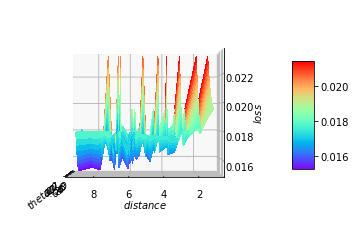

In [46]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.rainbow,
                       linewidth=0, antialiased=False)
ax.set_xlabel('$theta$')
ax.set_ylabel('$distance$')
ax.set_zlabel('$loss$')
# Customize the z axis.
# ax.set_xlim(0.051, 0.054)
# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.view_init(0, 180)
# ax.view_init(0, 0)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.savefig('fig1.png')
plt.show()

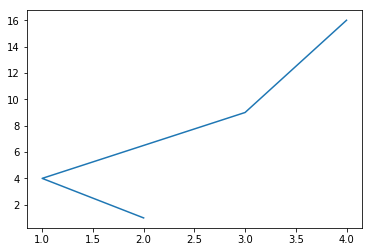

In [115]:
plt.plot([2, 1, 3, 4], [1, 4, 9, 16])

### How much are they similar to each other?

In [214]:
def average_distance(model1, model2):
    w = zip(model1.get_weights(), model2.get_weights())
    lw = list(w)
    sums = 0
    i = 0
    for ww in lw:
        i += 1
        sums += np.average(np.absolute(ww[0] - ww[1]))
    return sums / i

In [215]:
average_distance(model1, model2)

0.05077916461353501

In [209]:
cur_max = 0
i = 0
for ww in lw:
    i += 1
    cur_max = max(np.max(np.absolute(ww[0] - ww[1])), cur_max)

In [210]:
cur_max

0.13698825

In [213]:
import numpy as np
pi_list = list(np.arange(0, 1.05, 0.05)) # P for perturbations

weights = [model1.get_weights(), model2.get_weights()]
model_weights_list = list()
for pi in pi_list:
    agg_weights = list()
    for weights_list_tuple in zip(*weights):
        agg_weights.append(np.array([np.average(np.array(w), axis=0, weights=[1. - pi, pi]) for w in zip(*weights_list_tuple)]))
    model_weights_list.append(agg_weights)
    
model_list2 = list()
for _ in range(len(pi_list)):
    model_list2.append(tf.keras.models.clone_model(model1))
    
for i in range(len(model_list)):
    model_list2[i].set_weights(model_weights_list[i])

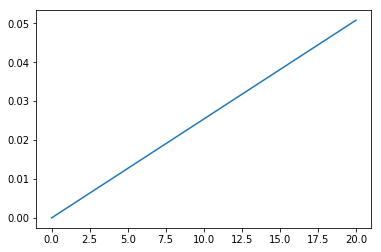

In [217]:
plt.plot([average_distance(model1, m) for m in model_list2])
plt.show()

### backup results

In [ ]:
%tensorboard --logdir logs

In [ ]:
a = 2

## @TODO Experiment with pretrained model

In [159]:
pretrained_model1 = tf.keras.models.clone_model(model1)
pretrained_model2 = tf.keras.models.clone_model(model1)